<a href="https://colab.research.google.com/github/sofiaElenaHopartean/NLP_recipes/blob/main/recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup and imports

In [ ]:
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_sm

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
import pandas as pd
import numpy as np
import csv
# import explacy
from spacy import displacy
from spacy.util import minibatch, compounding
import random
import time

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

### Dataset cleaning 

In [ ]:
recipes_df = pd.read_csv("drive/MyDrive/recipes.csv", delimiter=";")
recipes_df.head(3)

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water.**Stir in sugar, ...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001
2,Applesauce Bread I Recipe,124,https://images.media-allrecipes.com/userphotos...,GAF55,10 m,1 h 20 m,1 h 30 m,"flour,egg,white sugar,vegetable oil,applesauce...",Preheat oven to 350 degrees F (175 degrees C)....,7003


In [ ]:
recipes_df.describe()

,RecipeID
count,12351.000000
mean,16149.829326
std,5745.770833
min,7000.000000
25%,11150.500000
50%,15564.000000
75%,20889.500000
max,27546.000000


In [ ]:
recipes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12351 entries, 0 to 12350
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Recipe Name   12351 non-null  object
 1   Review Count  12351 non-null  object
 2   Recipe Photo  12351 non-null  object
 3   Author        12351 non-null  object
 4   Prepare Time  12351 non-null  object
 5   Cook Time     12351 non-null  object
 6   Total Time    12351 non-null  object
 7   Ingredients   12351 non-null  object
 8   Directions    12345 non-null  object
 9   RecipeID      12351 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 965.0+ KB


In [ ]:
recipes_df.isnull().sum()

Recipe Name     0
Review Count    0
Recipe Photo    0
Author          0
Prepare Time    0
Cook Time       0
Total Time      0
Ingredients     0
Directions      6
RecipeID        0
dtype: int64

In [ ]:
recipes_df[recipes_df['Directions'].isna()]
# recipes_df[recipes_df.isna().any(axis=1)]

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
292,Sunshine Cake Recipe,9,https://images.media-allrecipes.com/userphotos...,Helga,X,X,X,"egg,white sugar,water,flour,baking powder,salt...",NaN,7378
3818,Cherry Pie I Recipe,11,https://images.media-allrecipes.com/userphotos...,Cali,X,X,X,"vanilla,gelatin,water,cherry,white sugar,corns...",NaN,12251
4320,Quick Clam Chowder Recipe,42,https://images.media-allrecipes.com/userphotos...,Lew Sweet,X,X,X,"england,potato,celery,clam,onion,celery,margar...",NaN,12981
6238,Hot Clam Dip II Recipe,30,https://images.media-allrecipes.com/userphotos...,lara,X,X,X,"bread,cream cheese,onion,beer,worcestershire s...",NaN,15648
9330,Chocolate Sausage (Salame di Cioccolato) Recipe,2,https://images.media-allrecipes.com/images/795...,Manuela,X,X,X,"white sugar,egg,egg,butter,cocoa powder,cookie...",NaN,21002
10676,Oatmeal Kiss Cookies Recipe,6,https://images.media-allrecipes.com/userphotos...,HersheysKitchens.com,X,X,X,"chocolate,butter,shortening,white sugar,brown ...",NaN,24031


In [ ]:
recipes_df_small = recipes_df[~recipes_df['Directions'].isna()][["Directions", "Ingredients"]]

In [ ]:
recipes_df_small.shape

(12345, 2)

In [ ]:
recipes_df_small.head()

,Directions,Ingredients
0,"Dissolve yeast in warm water.**Stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,..."
1,'Preheat oven to 350 degrees F (175 degrees C)...,"flour,salt,baking powder,poppy,butter,vegetabl..."
2,Preheat oven to 350 degrees F (175 degrees C)....,"flour,egg,white sugar,vegetable oil,applesauce..."
3,Preheat oven to 350 degrees F (175 degrees C)....,"flour,baking powder,baking soda,salt,cinnamon,..."
4,Mix oats with buttermilk. Let stand for 1/2 h...,"oat,buttermilk,vegetable oil,egg,brown sugar,f..."


In [ ]:
directions_lengths = [ sum(not chr.isspace() for chr in str) for str in recipes_df_small["Directions"]]
ingredients_lengths = [ sum(not chr.isspace() for chr in str) for str in recipes_df_small['Ingredients']]

In [ ]:
print(directions_lengths[:10])
print(ingredients_lengths[:10])

[548, 446, 269, 293, 261, 459, 583, 139, 323, 277]
[51, 124, 94, 107, 77, 59, 72, 75, 97, 101]


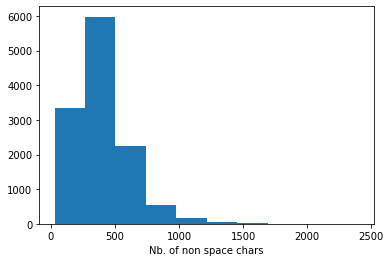

In [ ]:
plt.hist(directions_lengths)
plt.xlabel("Nb. of non space chars")
plt.show()

In [ ]:
small_directions = [len_ for len_ in directions_lengths if len_ <=10]
small_directions

[]

In [ ]:
print( list(set (''.join(recipes_df_small["Directions"]))))
print( list(set (''.join(recipes_df_small["Ingredients"]))))

['Q', 'E', '0', 't', 'p', 'F', 'R', '*', '?', 'J', '3', 'v', 'm', 'O', 'S', '7', 'w', '!', 'j', 's', '(', 'D', '&', 'C', 'W', 'T', 'L', ',', '"', '-', ' ', 'g', '1', '5', 'M', 'n', ')', '.', 'I', 'c', 'G', '/', 'l', 'U', 'P', '9', 'K', 'k', 'Z', 'e', 'o', '8', '{', 'b', '4', 'r', '#', '>', 'X', 'A', '<', 'q', 'H', ':', '2', 'y', 'd', 'h', 'z', '=', 'x', "'", 'a', 'f', 'B', 'Y', '%', 'é', 'i', '6', 'V', 'u', 'N', '}', '+']
['h', 'd', 'k', 'j', 'z', 'E', 's', '0', '(', 'Z', 't', 'e', 'D', 'p', 'o', 'C', 'F', 'W', '8', 'x', 'b', ',', 'L', 'r', 'T', 'R', '4', "'", 'a', 'g', 'f', ' ', '1', 'B', 'M', '-', 'n', '5', 'A', 'Y', ')', 'q', 'H', '.', 'J', '3', 'I', 'c', ':', 'G', '®', 'i', 'v', '2', '6', '/', 'm', 'u', 'l', 'O', 'S', '\x99', 'N', '7', 'U', 'w', 'P', '9', 'y']


In [ ]:
print([chr for chr in set(''.join(recipes_df_small["Directions"])) if not chr.isalnum()])
print([chr for chr in set(''.join(recipes_df_small["Ingredients"])) if not chr.isalnum()])

['*', '?', '!', '(', '&', ',', '"', '-', ' ', ')', '.', '/', '{', '#', '>', '<', ':', '=', "'", '%', '}', '+']
['(', ',', "'", ' ', '-', ')', '.', ':', '®', '/', '\x99']


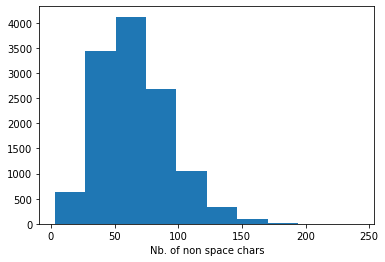

nb of non space chars: [(64, 5), (728, 4), (745, 4), (915, 10), (1009, 9), (3530, 9), (4885, 7), (4925, 8), (5073, 6), (5076, 10), (6829, 6), (7202, 10), (7817, 4), (8244, 10), (8552, 3), (8804, 10), (9091, 3), (10123, 7), (10177, 5), (11148, 4)]


In [ ]:
plt.hist(ingredients_lengths)
plt.xlabel("Nb. of non space chars")
plt.show()
small_ingreds = [(i, ingredients_lengths[i]) 
        for i in range(len(ingredients_lengths)) 
        if ingredients_lengths[i] <=10]
print("nb of non space chars:", small_ingreds)

In [ ]:
recipes_df_small.iloc[[i for i, _ in small_ingreds]]

,Directions,Ingredients
64,Thaw bread dough.**Preheat oven to 375 degrees...,bread
729,Preheat oven to 375 degrees F (190 degrees C)....,cake
746,Start with a cooled 9-inch square cake. From o...,cake
916,"In a large bowl, combine cake mix, peaches and...","cake,peach"
1010,'Prepare the cake according to package instruc...,"cake,side"
3531,"'Heap the flour, and make a well in it. Break...","flour,egg"
4888,Preheat oven to 300 degrees F (150 degrees C)....,pumpkin
4928,Preheat oven to 275 degrees F. (135 degrees C)...,"ham,cola"
5076,"Cut each tomato in half through the middle, n...",cherry
5079,Preheat the oven to 500 degrees F (260 degrees...,bell pepper


### EDA train set

In [ ]:
recipes_df_small.shape
# recipes_df_small.columns

(12345, 2)

In [ ]:
# X = recipes_df_small["Directions"].copy()
# y = recipes_df_small["Ingredients"].copy()

# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state= 11 )
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=11)

# print("Train: ", X_train.shape, y_train.shape)
# print("Val:", X_valid.shape, y_valid.shape)
# print("Test:", X_test.shape, y_test.shape)

In [ ]:
# recipe = X_train.iloc[1]
# print(recipe)
# z
# doc = nlp(recipe)
# print(doc)

# tokenized_text = pd.DataFrame()

# for i, token in enumerate(doc):
#   tokenized_text.loc[i, 'text'] = token.text
#   tokenized_text.loc[i, 'lemma'] = token.lemma_,
#   tokenized_text.loc[i, 'pos'] = token.pos_
#   tokenized_text.loc[i, 'tag'] = token.tag_
#   tokenized_text.loc[i, 'dep'] = token.dep_
#   tokenized_text.loc[i, 'shape'] = token.shape_
#   tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
#   tokenized_text.loc[i, 'is_stop'] = token.is_stop
#   tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

# tokenized_text

In [ ]:
# ingred_sample = y_train.iloc[1]
# print(ingred_sample)

# doc = nlp(ingred_sample)
# print(doc)

# tokenized_text = pd.DataFrame()

# for i, token in enumerate(doc):
#   tokenized_text.loc[i, 'text'] = token.text
#   tokenized_text.loc[i, 'lemma'] = token.lemma_,
#   tokenized_text.loc[i, 'pos'] = token.pos_
#   tokenized_text.loc[i, 'tag'] = token.tag_
#   tokenized_text.loc[i, 'dep'] = token.dep_
#   tokenized_text.loc[i, 'shape'] = token.shape_
#   tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
#   tokenized_text.loc[i, 'is_stop'] = token.is_stop
#   tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

# tokenized_text

### Preprocess data

In [ ]:
spacy.explain('NFP')

'superfluous punctuation'

In [ ]:
import sys
import warnings

warnings.filterwarnings("ignore")

In [ ]:
print([chr for chr in set(''.join(recipes_df_small["Directions"])) if not chr.isalnum()])
print([chr for chr in set(''.join(recipes_df_small["Ingredients"])) if not chr.isalnum()])

['*', '?', '!', '(', '&', ',', '"', '-', ' ', ')', '.', '/', '{', '#', '>', '<', ':', '=', "'", '%', '}', '+']
['(', ',', "'", ' ', '-', ')', '.', ':', '®', '/', '\x99']


In [ ]:
import unicodedata

In [ ]:
print([chr for chr in set(
    unicodedata.normalize('NFKD',
        ''.join(recipes_df_small["Directions"])).encode('ascii', 'ignore')
    ) ])
print([chr for chr in set(
    unicodedata.normalize('NFKD',
        ''.join(recipes_df_small["Ingredients"])).encode('ascii', 'ignore')
    ) ])

[32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125]
[32, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 87, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]


In [ ]:
print(unicodedata.normalize('NFKD', recipes_df_small["Directions"][1]).encode('ascii', 'ignore'))
print(unicodedata.normalize('NFKD', recipes_df_small["Ingredients"][1]).encode('ascii', 'ignore'))


b"'Preheat oven to 350 degrees F (175 degrees C). Grease bottoms of two 9-inch loaf pans.**Mix together flour, salt, baking powder, poppy seeds, butter flavoring, oil, eggs, milk, sugar, vanilla, and almond flavoring. Pour into prepared pans.**Bake at 350 degrees F (175 degrees C) for one hour. Cool 5 minutes. Poke holes in top of loaves and pour glaze over.**To make glaze: Mix orange juice, 1/2 teaspoon butter flavoring, 1/2 teaspoon almond flavoring, and 1 teaspoon vanilla. Add enough confectioners'' sugar to make glaze.**'"
b'flour,salt,baking powder,poppy,butter,vegetable oil,egg,milk,white sugar,vanilla,almond,orange juice,butter,almond,vanilla,sugar'


In [ ]:
unicodedata.normalize('NFKD', recipes_df_small["Ingredients"][1]).encode('ascii', 'ignore').decode("utf-8").split(",")


['flour',
 'salt',
 'baking powder',
 'poppy',
 'butter',
 'vegetable oil',
 'egg',
 'milk',
 'white sugar',
 'vanilla',
 'almond',
 'orange juice',
 'butter',
 'almond',
 'vanilla',
 'sugar']

In [ ]:
ingredients_not_found_in_sent = []
ingredients_found_multiple_times_in_sent = []
examples = []

LABEL = "INGREDIENT"

# ? ingred is space 

def define_ent_in_sentence(sentence, ingredients):
  ents= []
  ingred_not_found = 0
  samples = []
  sentence_lo = sentence.lower()
  for _ingred in sorted(ingredients.lower().split(","), key=len, reverse=True):
    start_pos = sentence_lo.find(_ingred)
    if ( start_pos != -1):
      _append = True
      end_pos = start_pos+len(_ingred)
      for a, b, _ in ents:
        if start_pos >= a and start_pos <= b:
          _append = False
        elif end_pos >= a and end_pos <= b:
          _append = False
      if _append: 
        ents.append((start_pos, end_pos, LABEL))
    else:
      splited_ingred = _ingred.split()
      found_one = False
      for _split_ingrd in splited_ingred:
        start_pos = sentence_lo.find(_split_ingrd)
        if ( start_pos != -1):
          end_pos = start_pos+len(_ingred)
          _append = True
          for a, b, _ in ents:
            if start_pos >= a and start_pos <= b:
              _append = False
            elif end_pos >= a and end_pos <= b:
              _append = False
          if _append: 
            ents.append((start_pos, end_pos, LABEL))
          found_one = True
      if not found_one: 
        # if len(examples) < 20:
        samples.append(_ingred)
        ingred_not_found += 1
  
  if ingred_not_found > 0: 
    # if len(examples) < 20:
    examples.append((sentence_lo, samples))
    ingredients_not_found_in_sent.append(ingred_not_found)
  
  return [sentence_lo, {'entities': ents}]

recipes_df_small['train_data']= np.vectorize(define_ent_in_sentence)(\
                                recipes_df_small['Directions'], 
                                recipes_df_small['Ingredients'])
recipes_df_small.head()

,Directions,Ingredients,train_data
0,"Dissolve yeast in warm water.**Stir in sugar, ...","yeast,water,white sugar,salt,egg,butter,flour,...","[dissolve yeast in warm water.**stir in sugar,..."
1,'Preheat oven to 350 degrees F (175 degrees C)...,"flour,salt,baking powder,poppy,butter,vegetabl...",['preheat oven to 350 degrees f (175 degrees c...
2,Preheat oven to 350 degrees F (175 degrees C)....,"flour,egg,white sugar,vegetable oil,applesauce...",[preheat oven to 350 degrees f (175 degrees c)...
3,Preheat oven to 350 degrees F (175 degrees C)....,"flour,baking powder,baking soda,salt,cinnamon,...",[preheat oven to 350 degrees f (175 degrees c)...
4,Mix oats with buttermilk. Let stand for 1/2 h...,"oat,buttermilk,vegetable oil,egg,brown sugar,f...",[mix oats with buttermilk. let stand for 1/2 ...


In [ ]:
recipes_df_small['Directions'][1].lower()

"'preheat oven to 350 degrees f (175 degrees c). grease bottoms of two 9-inch loaf pans.**mix together flour, salt, baking powder, poppy seeds, butter flavoring, oil, eggs, milk, sugar, vanilla, and almond flavoring. pour into prepared pans.**bake at 350 degrees f (175 degrees c) for one hour. cool 5 minutes. poke holes in top of loaves and pour glaze over.**to make glaze: mix orange juice, 1/2 teaspoon butter flavoring, 1/2 teaspoon almond flavoring, and 1 teaspoon vanilla. add enough confectioners'' sugar to make glaze.**'"

5105


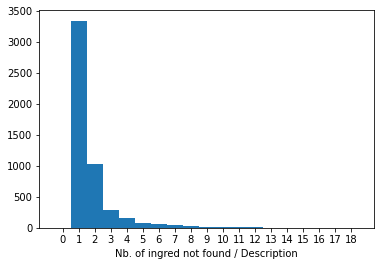

In [ ]:
print(len(ingredients_not_found_in_sent))
plt.hist(ingredients_not_found_in_sent, bins=np.arange(20)-0.5)
plt.xticks(range(19))
plt.xlabel("Nb. of ingred not found / Description")
plt.show()

In [ ]:
# [ ex[1] for ex in examples]
_a = ["1/3 cup masa harina",
"10 fluid ounces Mountain Dew\x99",
"2 cups half-and-half"]
[ ex for ex in examples for ingred in _a if ingred in ex[1]]


[('in a medium bowl beat butter until it is creamy. add the mexican corn flour and water and beat until well mixed.**using a food processor,  process thawed corn, but leave chunky. stir into the butter mixture.**in a separate bowl, mix cornmeal, sugar, cream, salt, and baking powder. add to corn flour mixture and stir to combine. pour batter into an ungreased 8x8 inch baking pan. smooth batter and cover with aluminum foil. place pan into a 9x13 inch baking dish that is filled a third of the way with water.**bake in a preheated 350 degree oven f (175 degrees c) oven for 50 to 60 minutes. allow to cool for 10 minutes. use an ice cream scoop for easy removal from pan.**',
  ['1/3 cup masa harina']),
 ('heat oil over high heat in a large skillet.  brown chicken.  reduce heat, and add garlic and mushrooms.  cook until soft.   remove chicken and mushrooms from the skillet.**pour half and half cream into skillet, and bring to a boil over high heat.  reduce heat to medium, and reduce.  stir oc

In [ ]:
recipes_df_small['train_data'][0]

['dissolve yeast in warm water.**stir in sugar, salt, eggs, butter, and 2 cups of flour. beat until smooth. mix in remaining flour until smooth. scrape dough from side of bowl. knead dough, then cover it and let rise in a warm place until double (about 1 1/2 hours).**punch down dough. divide in half. roll each half into a 12-inch circle. spread with butter. cut into 10 to 15 wedge. roll up the wedges starting with the wide end. place rolls with point under on a greased baking sheet. cover and let rise until double (about 1 hour).**bake at 400 degrees f (205 degrees c) for 12-15 minute or until golden brown. brush tops with butter when they come out of the oven.**',
 {'entities': [(39, 50, 'INGREDIENT'),
   (58, 64, 'INGREDIENT'),
   (9, 14, 'INGREDIENT'),
   (23, 28, 'INGREDIENT'),
   (80, 85, 'INGREDIENT'),
   (52, 55, 'INGREDIENT')]}]

In [ ]:
[x[0] for x in recipes_df_small['train_data'][1:10]]

["'preheat oven to 350 degrees f (175 degrees c). grease bottoms of two 9-inch loaf pans.**mix together flour, salt, baking powder, poppy seeds, butter flavoring, oil, eggs, milk, sugar, vanilla, and almond flavoring. pour into prepared pans.**bake at 350 degrees f (175 degrees c) for one hour. cool 5 minutes. poke holes in top of loaves and pour glaze over.**to make glaze: mix orange juice, 1/2 teaspoon butter flavoring, 1/2 teaspoon almond flavoring, and 1 teaspoon vanilla. add enough confectioners'' sugar to make glaze.**'",
 'preheat oven to 350 degrees f (175 degrees c).  grease and flour two 9 x 5 inch loaf pans.**beat together eggs, sugar, and oil.  blend in applesauce, and then sour cream or buttermilk.  mix in flour, baking powder, soda, and cinnamon. stir in raisins. pour batter into prepared pans.**bake for 80 minutes.  cool on wire racks.**',
 'preheat oven to 350 degrees f (175 degrees c).  grease and flour an 8 1/2 x 4 1/2 inch loaf pan.**in a large bowl, combine flour, b

### Train val test split 

In [ ]:
X = recipes_df_small["Directions"].copy()
y = recipes_df_small["train_data"].copy()

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state= 11 )
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=11)

print("Train: ", X_train.shape, y_train.shape)
print("Val:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train:  (9876,) (9876,)
Val: (1234,) (1234,)
Test: (1235,) (1235,)


### SpaCy custom NER model 

In [ ]:
import time
# A simple decorator to log function processing time
def timer(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print("Completed in {} seconds".format(int(te - ts)))
        return result
    return timed

In [38]:
# Data must be of the form (sentence, {entities: [start, end, label]})
@timer
def train_spacy(train_data, iterations, dropout = 0.2, display_freq = 1):
    ''' Train a spacy NER model, which can be queried against with test data
    
    train_data : training data in the format of (sentence, {entities: [(start, end, label)]})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    nlp = spacy.blank('en') 
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    
    # Add entity labels to the NER pipeline
    # for i in labels:
    ner.add_label(LABEL)

    # Disable other pipelines in SpaCy to only train NER
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        nlp.vocab.vectors.name = 'spacy_model' # without this, spaCy throws an "unnamed" error
        optimizer = nlp.begin_training()
        for itr in range(iterations):
            random.shuffle(train_data) # shuffle the training data before each iteration
            losses = {}
            batches = minibatch(train_data, size = compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(           
                    texts,
                    annotations, 
                    drop = dropout,   
                    sgd = optimizer,
                    losses = losses)
            if itr % display_freq == 0:
                print("Iteration {} Loss: {}".format(itr + 1, losses))
    return nlp

# Train (and save) the NER model
ner = train_spacy(y_train.tolist(), 10)
ner.to_disk("spacy_example1")

Iteration 1 Loss: {'ner': 32182.032454935783}
Iteration 2 Loss: {'ner': 24353.736446388582}
Iteration 3 Loss: {'ner': 23041.81111089932}
Iteration 4 Loss: {'ner': 21081.916618189138}
Iteration 5 Loss: {'ner': 20720.755212162858}
Iteration 6 Loss: {'ner': 19940.77931718046}
Iteration 7 Loss: {'ner': 18997.395321257936}
Iteration 8 Loss: {'ner': 18863.184862197242}
Iteration 9 Loss: {'ner': 18099.74205708565}
Iteration 10 Loss: {'ner': 18085.939230897253}
Completed in 1649 seconds


In [40]:
ner.to_disk("drive/MyDrive/recipes/spacy_model1")

 Test model on new data: validation set

In [ ]:
def load_model(model_path):
    ''' Loads a pre-trained model for prediction on new test sentences
    
    model_path : directory of model saved by spacy.to_disk
    '''
    nlp = spacy.blank('en') 
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    ner = nlp.from_disk(model_path)
    return ner

In [ ]:
y_valid.tolist()[:6]

NameError: ignored

In [ ]:
test_sent = y_val.tolist()